In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [2]:
df = (
    pd.read_csv('train_houses_reg.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

In [3]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

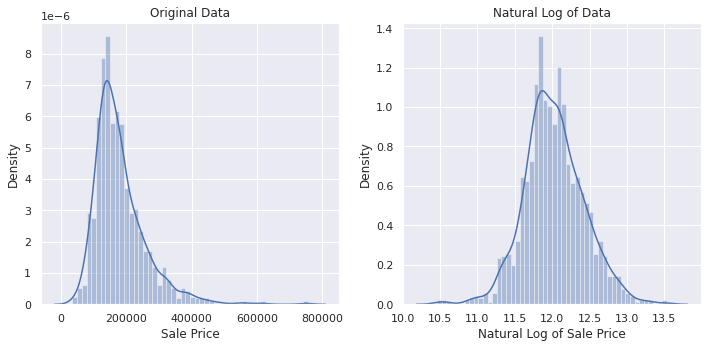

In [4]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев,
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [5]:
X.shape
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
### Your code is here
X = X.dropna(axis = 1, thresh = 0.85*X.shape[0])
len(list(X.columns))

73

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные.

In [5]:
unwanted_num_cols = ['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']

cat_cols = list(X.select_dtypes(include='object').columns)
cat_cols += unwanted_num_cols
### Выделим вещественные фичи

X[cat_cols] = X[cat_cols].astype('object')

num_cols = list(X.select_dtypes(exclude='object').columns)
num_cols = [n for n in num_cols if n not in unwanted_num_cols]

### Заполним пропуски как и хотели!

X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])


In [7]:
X.to_csv('res_1.csv', sep = ',', index = False)

In [6]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    log_target,
                                                    test_size=0.25,
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [7]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cols_for_ohe = [x for x in cat_cols if X[x].nunique() < 5]
cols_for_mte = [x for x in cat_cols if X[x].nunique() >= 5]

cols_for_ohe_idx = [list(X.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X.columns).index(col) for col in num_cols]

t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeRegressor())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 22, 24, 27,
                                                   28, 29, 38, 50, 56, 61]),
                                                 ('MeanTragetencoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 18,
                                                   19, 20, 21, 25, 26, 30, 32,
                                                   36, 37, 39, 52, 54, 59, 60,
                                                   71, 72, 69, 70, 55, 16,
                                                   17]),
                                                 ('StandarScaler',
                                                  StandardScaler(),
                                                  [0, 2, 14, 15, 23, 31, 33, 34,
                                                   35, 40, 41, 42, 43, 44, 45,
                                                   46, 47, 48, 49, 51, 53, 57,
                                                   58, 62, 63, 64, 65, 66, 67,
                                                   68, ...])])),
                ('decision_tree', DecisionTreeRegressor())])

In [10]:
train_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error}")
print(f"Качество на тесте: {test_error}")

Качество на трейне: 8.645051016120677e-33
Качество на тесте: 0.04532717656322537


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [17]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

### Your code is here
custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]
pipe_rf = Pipeline([('column_transformer', col_transform),
                   ('random_forest', RandomForestRegressor(random_state = 1))])

search = GridSearchCV(pipe_rf,
                     param_grid,
                     cv = custom_cv,
                     scoring='neg_mean_squared_error',
                     verbose = 10)
search.fit(X, log_target)
print(f'Best parameter (CV score={search.best_score_:5f}):')
print(search.best_params_)


Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 1/1; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.018 total time=   2.4s
[CV 1/1; 2/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5
[CV 1/1; 2/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.018 total time=   2.3s
[CV 1/1; 3/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10
[CV 1/1; 3/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.018 total time=   2.2s
[CV 1/1; 4/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2
[

Попробуем теперь поэкспериментировать с бэггингами.

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!).

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

### Your code is here
np.random.seed = 1
results = []

bag_list = [BaggingRegressor(LinearRegression(),
                            n_estimators = 100,
                            n_jobs = -1,
                            random_state = 1),
           BaggingRegressor(RandomForestRegressor(),
                           n_estimators = 100,
                           n_jobs = -1,
                           random_state = 1),
           BaggingRegressor(DecisionTreeRegressor(),
                           n_estimators = 100,
                           n_jobs = -1,
                           random_state = 1)]

for regressor in bag_list:
    pipe_bag = Pipeline([('column_transformer', col_transform,),
                         ('bagging', regressor)])
    pipe_bag.fit(X_train, y_train)
    
    train_preds = pipe_bag.predict(X_train)
    test_preds = pipe_bag.predict(X_test)
    
    train_error = np.mean((train_preds - y_train)**2)
    test_error = np.mean((test_preds - y_test)**2)
    
    results.append([train_error, test_error])


In [13]:
results

[[0.014749045963677248, 0.016854286696385824],
 [0.007349555392565252, 0.018398688350244],
 [0.0028936305214436343, 0.018110210757301584]]

Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

Строить бэггинг над лесом нет смысла, потому что отдельные леса слишком сильно коррелируют. Над линейкой тоже бессмысленно, ведь бэггинг над линейкой будет по сути очередной линейкой.

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [8]:
### Your code is here
def first_grliv(x):
    if x['GrLivArea'] == 0:
        return 0
    return x['1stFlrSF'] * 100 / x['GrLivArea']

X_train['1stFlrPercent'] = X_train.apply(lambda x: first_grliv(x), axis = 1)
X_test['1stFlrPercent'] = X_test.apply(lambda x: first_grliv(x), axis = 1)
X['1stFlrPercent'] = X.apply(lambda x: first_grliv(x), axis = 1)

In [9]:
def bsmt_total(x):
    if x['BsmtFinSF1'] == 0:
        return 0
    return x['BsmtFinSF1'] * 100 / x['TotalBsmtSF']
X_train['BsmtFinPercent'] = X_train.apply(lambda x: bsmt_total(x), axis = 1)
X_test['BsmtFinPercent'] = X_test.apply(lambda x: bsmt_total(x), axis = 1)
X['BsmtFinPercent'] = X.apply(lambda x: bsmt_total(x), axis = 1)

In [10]:
def old_house(x):
    return int(x['YrSold'])-int(x['YearBuilt'])
X_train['Old'] = X_train.apply(lambda x: old_house(x), axis = 1)
X_test['Old'] = X_test.apply(lambda x: old_house(x), axis = 1)
X['Old'] = X.apply(lambda x: old_house(x), axis = 1)

In [11]:
def total_square(x):
    return x['1stFlrSF'] + x['2ndFlrSF'] + x['TotalBsmtSF']
X_train['TotalSquare'] = X_train.apply(lambda x: total_square(x), axis = 1)
X_test['TotalSquare'] = X_test.apply(lambda x: total_square(x), axis = 1)
X['TotalSquare'] = X.apply(lambda x: total_square(x), axis = 1)

In [12]:
print(X.shape[1], X_test.shape[1], X_train.shape[1])

77 77 77


In [13]:
numeric_cols_idx += [X.shape[1]-i for i in range(1,5)]
t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTragetencoder', TargetEncoder(), cols_for_mte_idx),
     ('StandarScaler', StandardScaler(), numeric_cols_idx)]
col_transform = ColumnTransformer(transformers=t)

In [18]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe_rf = Pipeline([("column_transformer",
                     col_transform),

                    ("random_forest",
                     RandomForestRegressor(random_state=1))])

search = GridSearchCV(pipe_rf,
                      param_grid,
                      cv=custom_cv,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X, log_target)

print(search.best_params_)

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 1/1; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.018 total time=   2.4s
[CV 1/1; 2/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5
[CV 1/1; 2/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.018 total time=   2.2s
[CV 1/1; 3/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10
[CV 1/1; 3/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.018 total time=   2.1s
[CV 1/1; 4/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2
[

In [21]:
pipe_rf = Pipeline([('col_transformer', col_transform),
                    ('random_forest', RandomForestRegressor(max_depth = 15,
                                                             min_samples_leaf = 1,
                                                             min_samples_split = 2))])
pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 22, 24, 27,
                                                   28, 29, 38, 50, 56, 61]),
                                                 ('MeanTragetencoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 18,
                                                   19, 20, 21, 25, 26, 30, 32,
                                                   36, 37, 39, 52, 54, 59, 60,
                                                   71, 72, 69, 70, 55, 16,
                                                   17]),
                                                 ('StandarScaler',
                                                  StandardScaler(),
                                                  [0, 2, 14, 15, 23, 31, 33, 34,
                                                   35, 40, 41, 42, 43, 44, 45,
                                                   46, 47, 48, 49, 51, 53, 57,
                                                   58, 62, 63, 64, 65, 66, 67,
                                                   68, ...])])),
                ('random_forest', RandomForestRegressor(max_depth=20))])

In [22]:
train_preds = pipe_rf.predict(X_train)
test_preds = pipe_rf.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)

print(f"Ошибка на трейне: {train_error} \n", f"Ошибка на тесте: {test_error} \n")

Ошибка на трейне: 0.0028009099812457347 
 Ошибка на тесте: 0.017400196261987633 

